In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from CAP.collocation import *
import glob

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import cartopy.feature as cfeature

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.rc("font", family="serif")

/home/vmeijer/.conda/envs/gspy/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/vmeijer/.local/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [6]:
df = pd.read_pickle("../data/contrail_dataset_v9.pkl")
df_bal = df.groupby([df.goes_time, df.L1_file, df.goes_product, df.contrail_id])[["top_pressure_hPa"]].min() * 100
df_bal["alt_geom_km"] =  df.groupby([df.goes_time, df.L1_file, df.goes_product, df.contrail_id]).caliop_top_height.max() / 1000

df_bal[["caliop_lon", "caliop_lat"]] = df.groupby([df.goes_time, df.L1_file, df.goes_product, df.contrail_id])[["caliop_lon", "caliop_lat"]].mean()

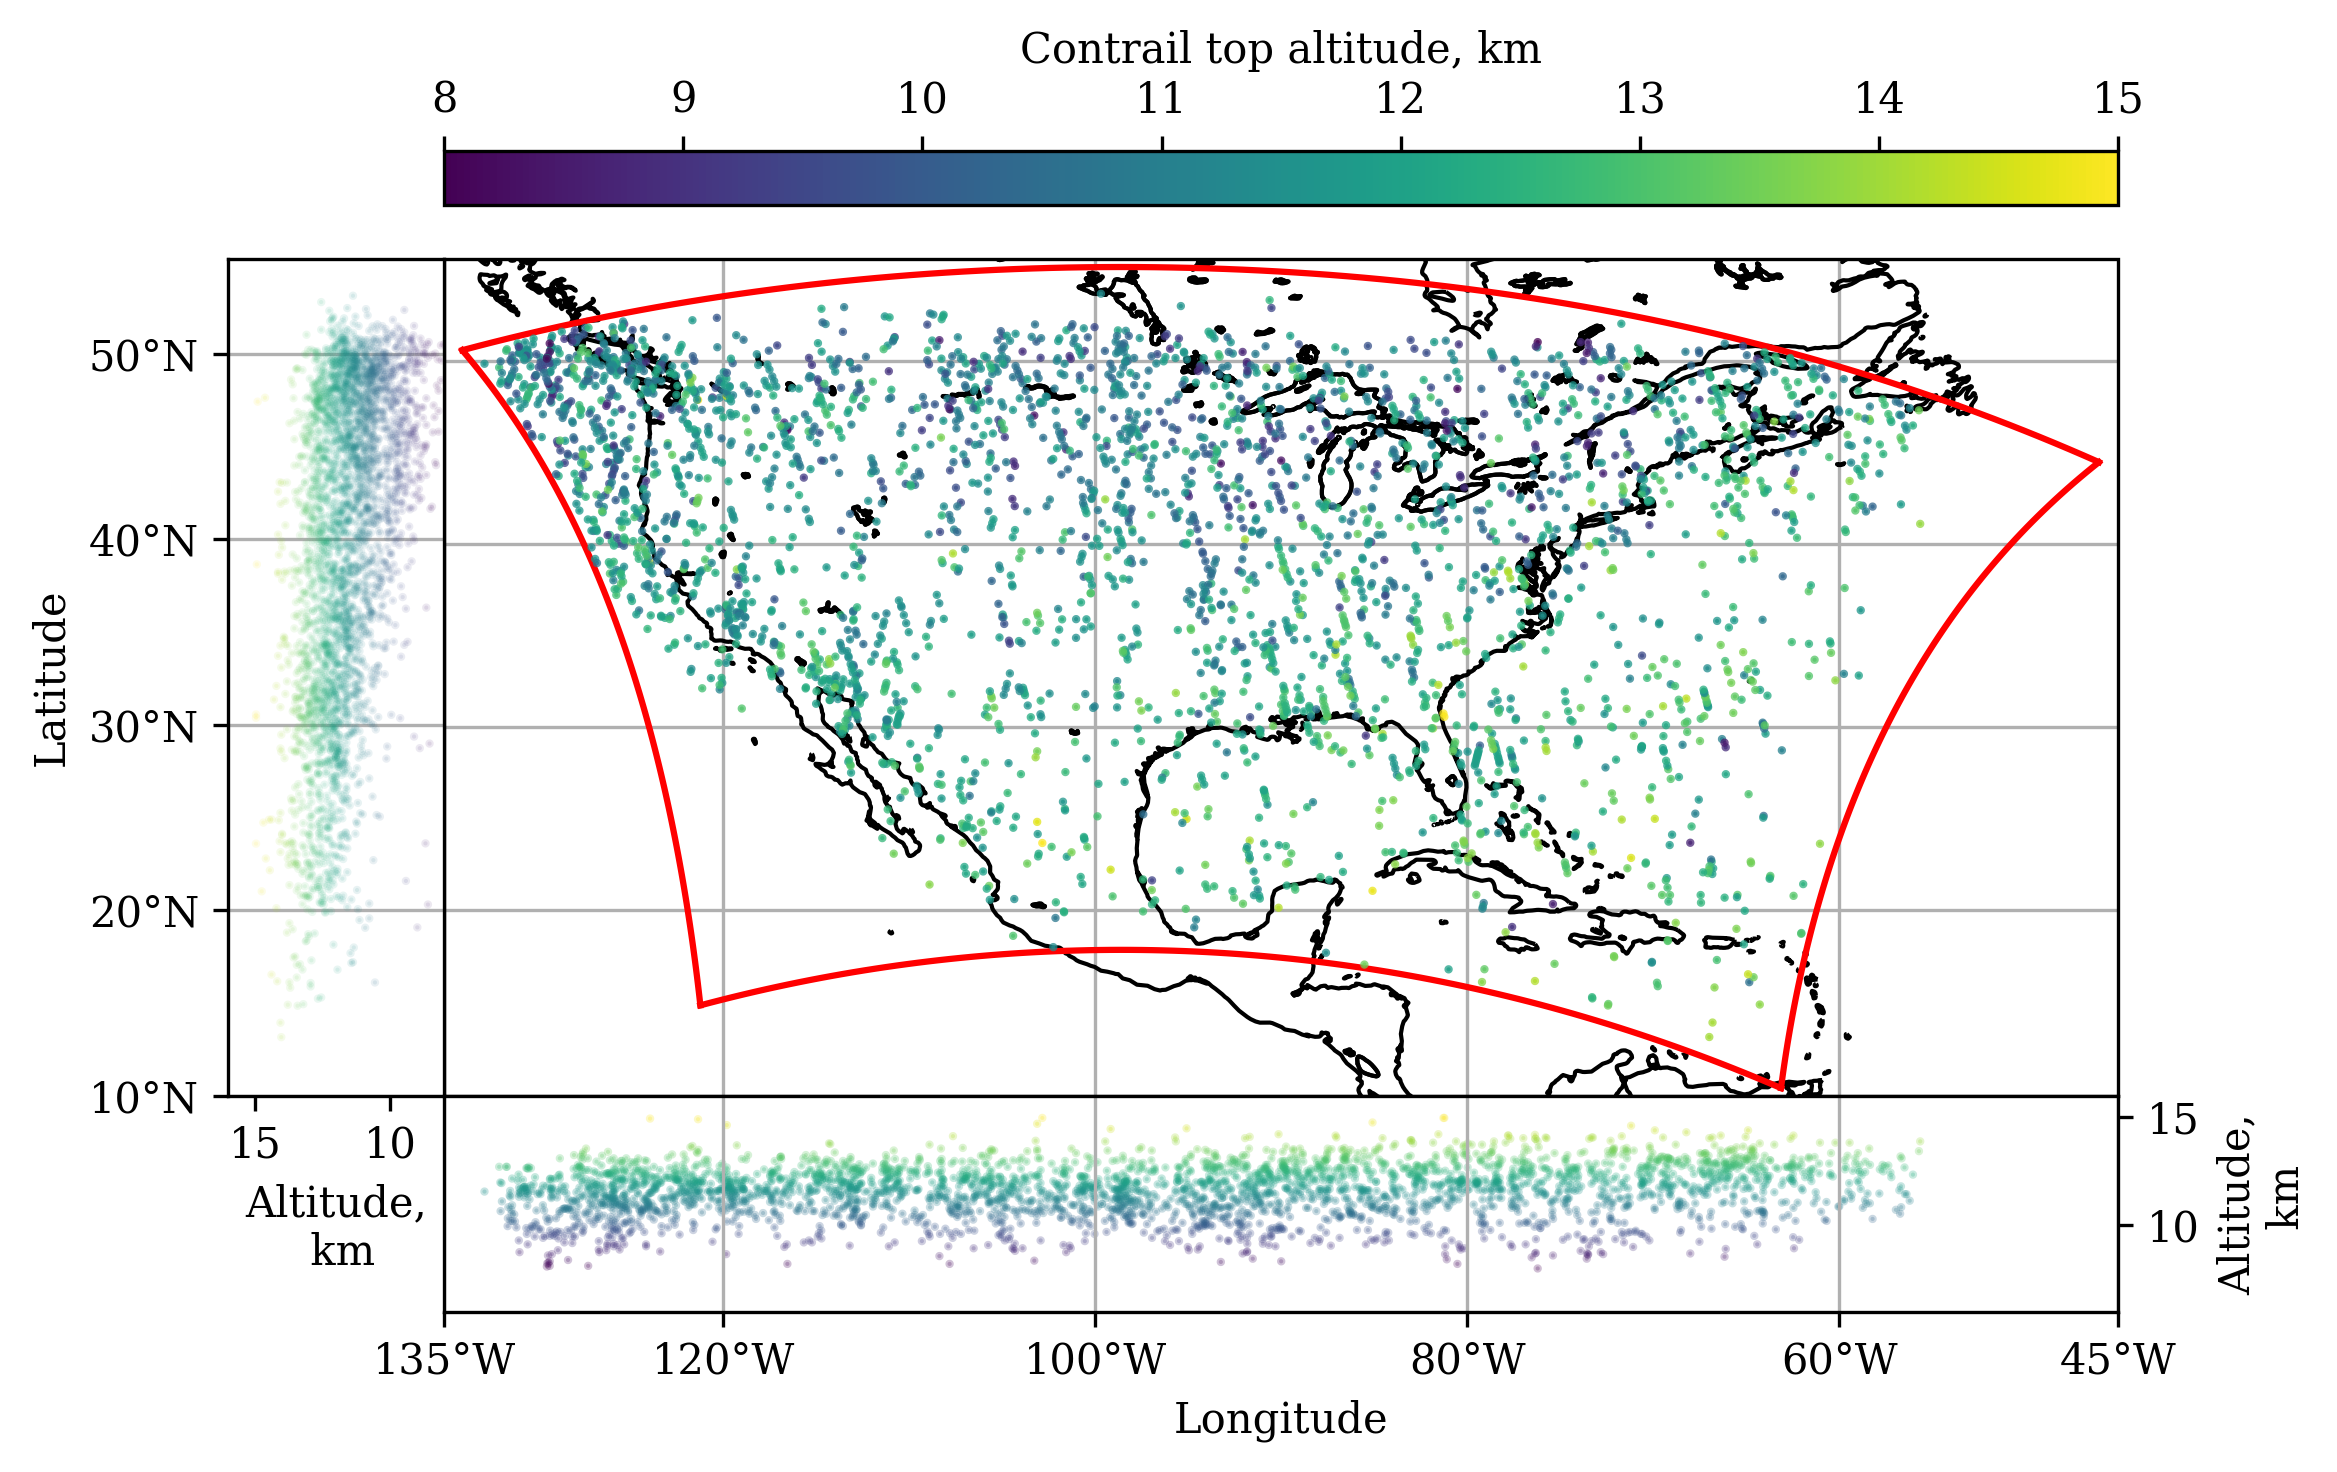

In [19]:
import matplotlib.patches as patches
import cartopy.crs as ccrs
from contrails.satellites.goes.abi import *


fig, ax = plt.subplots(dpi=300, figsize=(7.2, 7.2), subplot_kw={"projection": ccrs.PlateCarree()})

extent = [-135, -45, 10, 55]
ax.set_extent(extent)

data = df_bal.reset_index()

cf = ax.scatter(data.caliop_lon.values, data.caliop_lat.values, transform=ccrs.PlateCarree(),
          s=1, c=data.alt_geom_km.values, alpha=0.75, cmap="viridis", zorder=5,
               vmin=8, vmax=15)


gl = ax.gridlines(zorder=0, ylocs =[20, 30-0.175, 40-0.35, 50-0.5])
ax.set_extent(extent, ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAKES, fc="none", ec="k")

pos = ax.get_position()
cax = fig.add_axes([pos.x0, pos.y1+0.025, pos.x1 - pos.x0, 0.025])



plt.colorbar(ScalarMappable(cmap="viridis", norm=Normalize(vmin=8, vmax=15)),
                cax=cax, label="Contrail top altitude, km", orientation="horizontal")

cax.xaxis.tick_top()
cax.xaxis.set_label_position("top")

lax = fig.add_axes([pos.x0-0.1, pos.y0, 0.1, pos.y1-pos.y0])
bax = fig.add_axes([pos.x0, pos.y0-0.1, pos.x1-pos.x0, 0.1])


#sns.histplot(y="caliop_lat", data=data, ax=lax, binwidth=5)
lax.scatter(data.alt_geom_km, data.caliop_lat, s=1, alpha=0.1, c=data.alt_geom_km,
           vmin=8, vmax=15, cmap="viridis", zorder=2)
lax.set_xlim(8, 16)
lax.invert_xaxis()
#lax.xaxis.tick_top()
lax.xaxis.set_label_position('bottom') 
lax.set(ylabel="Latitude", xlabel="Altitude,\n km")
lax.yaxis.set_major_formatter(LatitudeFormatter())
lax.set_ylim(*extent[2:3])

lax.grid(axis='y')

# Remove rugplots as Steven doesn't like 'm
#sns.rugplot(data=data, y="caliop_lat", ax=lax, height=0.1, alpha=0.25, c="k")


bax.scatter(data.caliop_lon, data.alt_geom_km, s=1, alpha=0.25, c=data.alt_geom_km,
           vmin=8, vmax=15, cmap="viridis")

bax.set(xlabel="Longitude", ylabel="Altitude,\n km")
# bax.invert_yaxis()
bax.set_xlim(*extent[:2])
bax.set_xticks([-135, -120, -100, -80, -60, -45])
bax.grid(axis="x")
bax.set_ylim(6, 16)
bax.yaxis.tick_right()
bax.yaxis.set_label_position("right")
bax.xaxis.set_major_formatter(LongitudeFormatter())
# bax.set_yticks([500])

# Remove rugplots as Steven doesn't like 'm
#sns.rugplot(data=data, x="caliop_lon", ax=bax, height=0.1, alpha=0.1, c="k")


ax.plot(np.linspace(ORTHO_EXTENT[0], ORTHO_EXTENT[1], 100), [ORTHO_EXTENT[2]]*100, 
        c="r", zorder=2,
        transform=ORTHO_PROJ)

ax.plot(np.linspace(ORTHO_EXTENT[0], ORTHO_EXTENT[1], 100), [ORTHO_EXTENT[3]]*100, 
        c="r", zorder=2,
        transform=ORTHO_PROJ)
ax.plot([ORTHO_EXTENT[0]] * 100, np.linspace(ORTHO_EXTENT[2], ORTHO_EXTENT[3], 100),
        c="r", zorder=2,
        transform=ORTHO_PROJ)

ax.plot([ORTHO_EXTENT[1]] * 100, np.linspace(ORTHO_EXTENT[2], ORTHO_EXTENT[3], 100),
        c="r", zorder=2,
        transform=ORTHO_PROJ, label="Detection domain")


ax.add_feature(cfeature.LAKES, fc="none", ec="k", zorder=0)

# ax.add_patch(patches.Rectangle((ORTHO_EXTENT[0], ORTHO_EXTENT[2]), 
#                                width=ORTHO_EXTENT[1]-ORTHO_EXTENT[0],
#                               height=ORTHO_EXTENT[3]-ORTHO_EXTENT[2],
#                               transform=ORTHO_PROJ, facecolor="none", edgecolor="r",zorder=2,
#                               label="Detection domain"))

#plt.savefig("geographic_overview.png", dpi=300, bbox_inches="tight")